In [110]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
from lacbox.io import load_pwr, load_oper
from pathlib import Path
from our_values import *
import pandas as pd
from lacbox.io import load_ctrl_txt
from scipy.optimize import curve_fit
from lacbox.io import ReadHAWC2
from lacbox.test import test_data_path
from lacbox.io import load_stats, load_oper
from scipy.integrate import trapezoid
import os
from scipy.integrate import simpson
from our_functions import DEL_calculation, filter

plt.rcParams.update({'font.family': 'serif', 'font.size':16})
from matplotlib.ticker import FormatStrFormatter



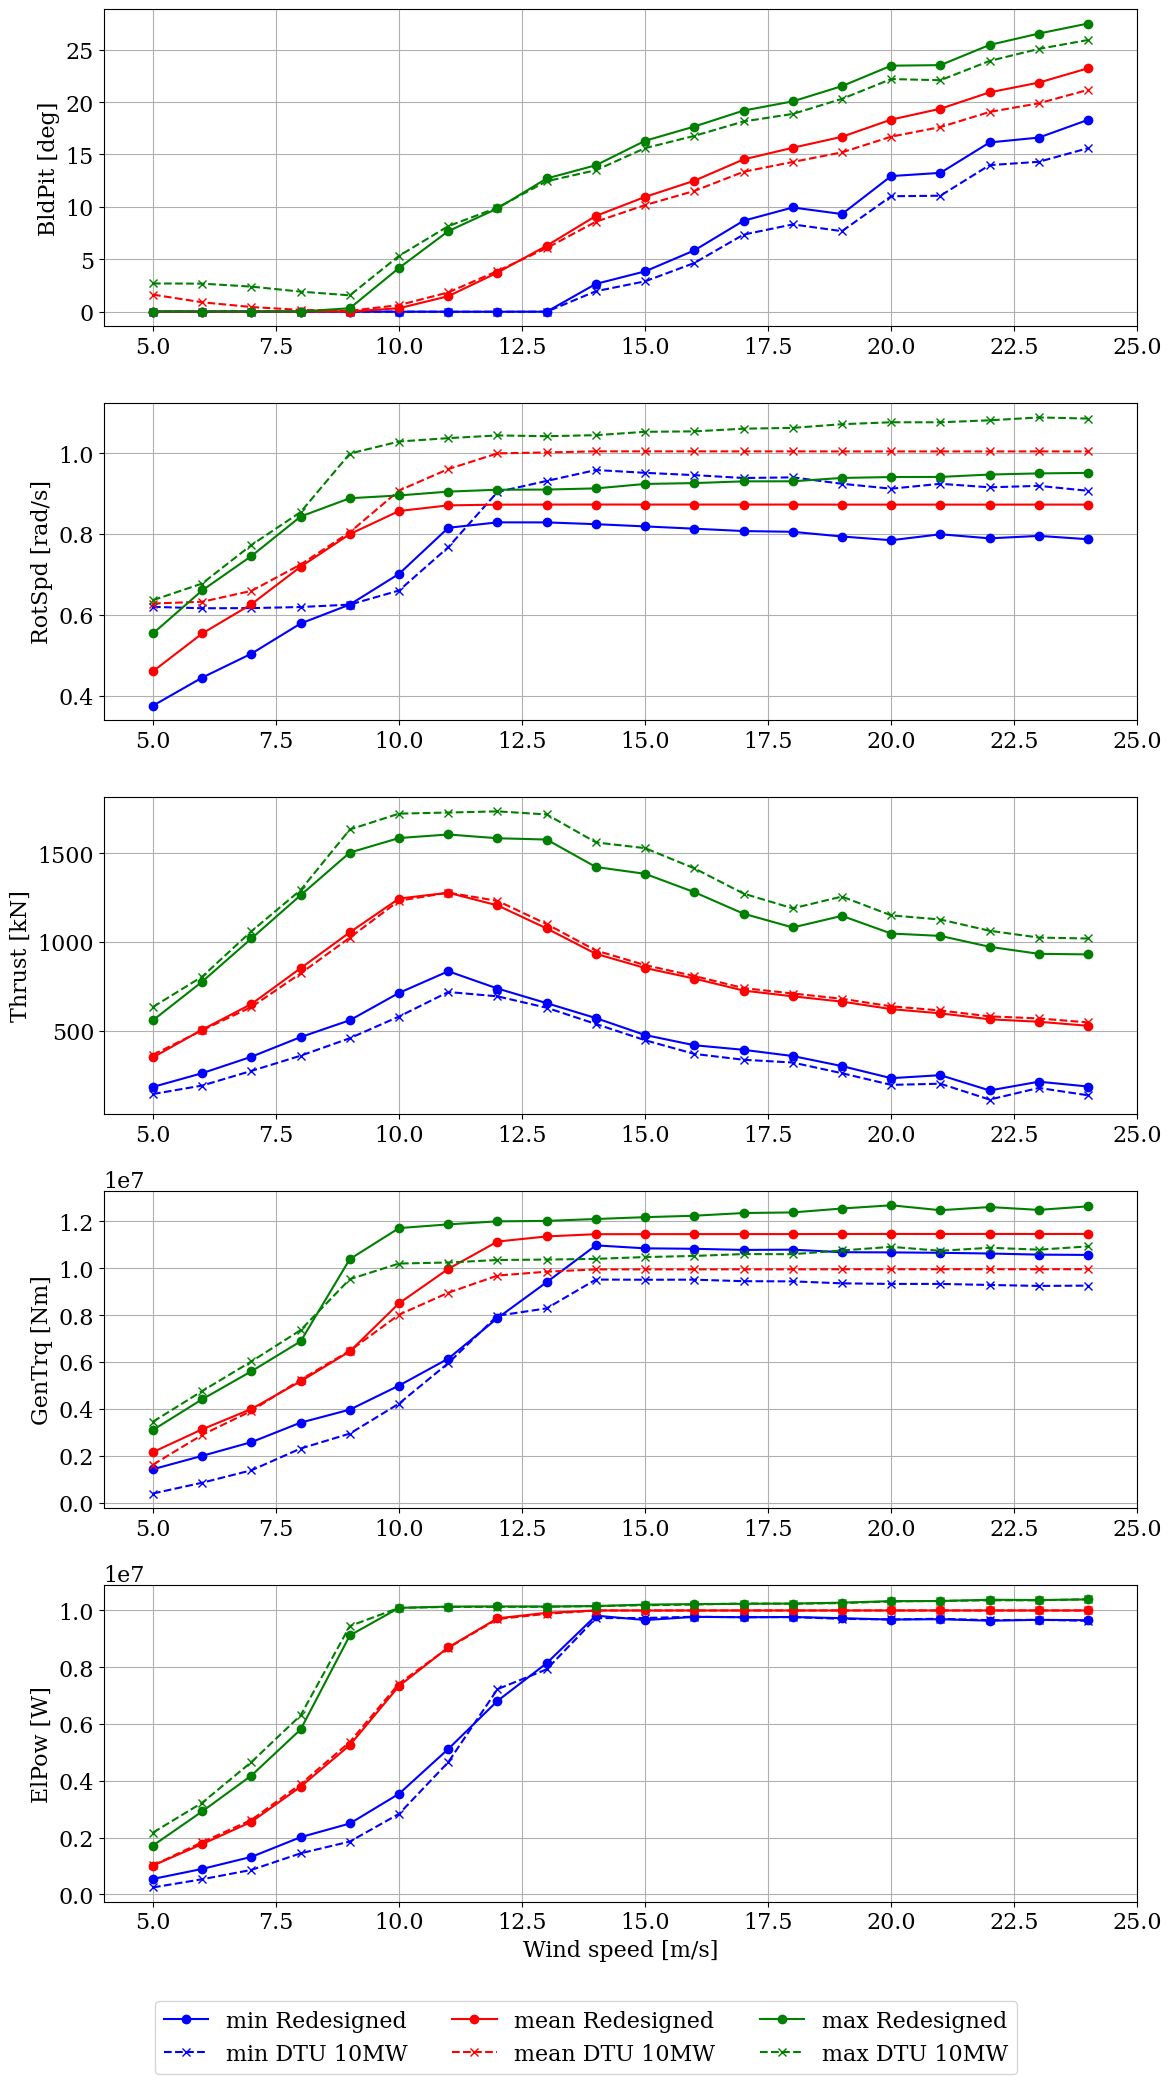

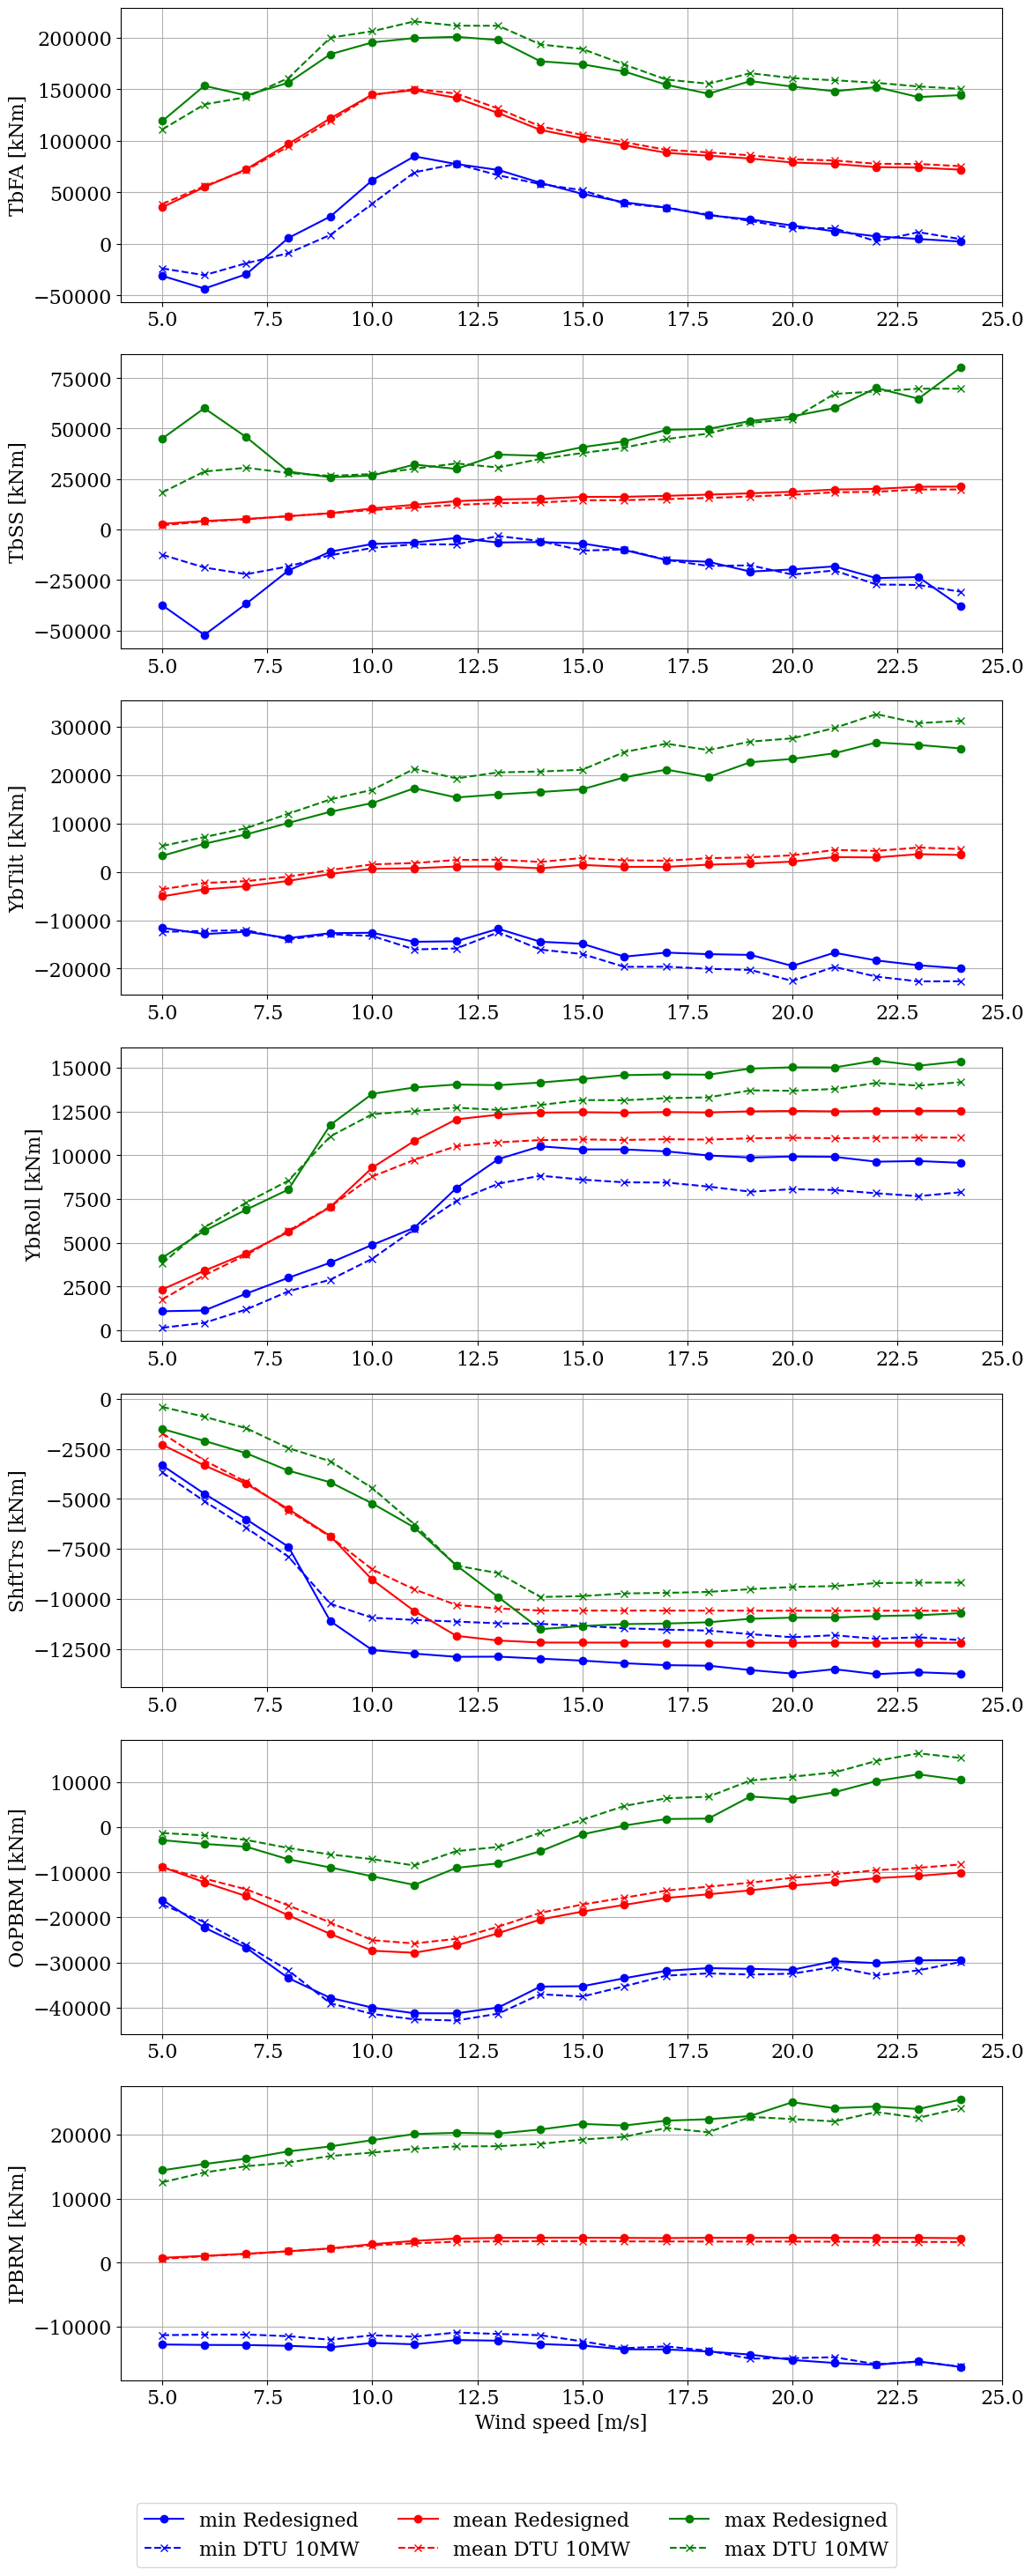

In [ ]:
# turbulent

STATS_PATH_DTU = 'dtu_10mw_turb_stats.hdf5'  # path to mean steady stats, CHANGE!!!!
STATS_PATH = 'Group1_turb.csv'

SUBFOLDER_DTU = 'tca'  # select a turbulence class
SUBFOLDER = 'tcb'  # select a turbulence class

CHAN_DESCS = {'BldPit': 'pitch1 angle',  # dictionary used to identify which descriptions
              'RotSpd': 'rotor speed',  # in the HAWC2 statistics file correspond to which
              'Thrust': 'aero rotor thrust',  # channels we want
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids_operation = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow']

chan_ids_loads = ['TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

# load the HAWC2 data from the stats file. Isolate the simulations with no tilt.
df_dtu, wsps_dtu = load_stats(STATS_PATH_DTU, subfolder=SUBFOLDER_DTU, statstype='turb')
df, wsps = load_stats(STATS_PATH, subfolder=SUBFOLDER, statstype='turb')

# initialize the figure and axes
fig, axs = plt.subplots(5, 1, figsize=(12, 20), clear=True)

value_list = ['min', 'mean', 'max']
value_list_dtu = ['min DTU 10MW', 'mean DTU 10MW', 'max DTU 10MW']
value_list_redesigned = ['min Redesigned', 'mean Redesigned', 'max Redesigned']
#warm_colors = ['#FF4500', '#FF00FF', '#FFD700']  # Orange-Red, Magenta, Yellow
#cold_colors = ['#1E90FF', '#00CED1', '#008000']  # Dodger Blue, Cyan, Green
color_list = ['b', 'r', 'g']

## OPERATION

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids_operation):

    # isolate the channel data
    chan_df = df.filter_channel(chan_id, CHAN_DESCS)
    chan_df_dtu = df_dtu.filter_channel(chan_id, CHAN_DESCS)

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    h2_wind = chan_df['wsp']
    h2_wind_dtu = chan_df_dtu['wsp']

    for i in range(len(value_list)):
        HAWC2val = chan_df[value_list[i]]
        HAWC2val_dtu = chan_df_dtu[value_list[i]]

        h2_wind, HAWC2val = np.array(h2_wind), np.array(HAWC2val) # wind speed, loads
        i_h2 = np.argsort(h2_wind) # sorts indexies so the wind speed array is in ascending order

        h2_wind_dtu, HAWC2val_dtu = np.array(h2_wind_dtu), np.array(HAWC2val_dtu) # wind speed, loads
        i_h2_dtu = np.argsort(h2_wind_dtu) # sorts indexies so the wind speed array is in ascending order


        ax = axs.flatten()[iplot]
        #ax.plot(h2_wind[i_h2], HAWC2val[i_h2], 'o', alpha = 0.1, color=color_list[i])  # HAWC2 turb results
        #ax.plot(h2_wind_dtu[i_h2_dtu], HAWC2val_dtu[i_h2_dtu], 'x', alpha = 0.1, color=color_list[i])  # HAWC2 turb results

        groups = [i_h2[i:i + 6] for i in range(0, len(i_h2), 6)]
        groups_dtu = [i_h2_dtu[i:i + 6] for i in range(0, len(i_h2_dtu), 6)]
        ws_array = np.zeros(20)
        average_array = np.zeros(20)
        max_max_array = np.zeros(20)
        min_min_array = np.zeros(20)
        ws_array_dtu = np.zeros(20)
        average_array_dtu = np.zeros(20)
        max_max_array_dtu = np.zeros(20)
        min_min_array_dtu = np.zeros(20)

        for idx, group in enumerate(groups): # index, group
            ws_array[idx] = h2_wind[groups[idx]][0]
            average_array[idx] = np.mean(HAWC2val[groups[idx]])
            if value_list[i]=='max':
                max_max_array[idx] = np.amax(HAWC2val[groups[idx]])
            
            if value_list[i]=='min':
                min_min_array[idx] = np.amin(HAWC2val[groups[idx]])

        for idx, group in enumerate(groups_dtu): # index, group
            ws_array_dtu[idx] = h2_wind_dtu[groups_dtu[idx]][0]
            average_array_dtu[idx] = np.mean(HAWC2val_dtu[groups_dtu[idx]])
            if value_list[i]=='max':
                max_max_array_dtu[idx] = np.amax(HAWC2val_dtu[groups_dtu[idx]])
            
            if value_list[i]=='min':
                min_min_array_dtu[idx] = np.amin(HAWC2val_dtu[groups_dtu[idx]])

        ax.plot(ws_array, average_array, '-o',  alpha = 1, label=value_list_redesigned[i], color=color_list[i])  # HAWC2 turb results
        ax.plot(ws_array_dtu, average_array_dtu, '--x',  alpha = 1, label=value_list_dtu[i], color=color_list[i])  # HAWC2 turb results
        
        #if value_list[i]=='max':
            #ax.plot(ws_array, max_max_array, '--',  alpha = 1, label=value_list[i], color=color_list[i])  # HAWC2 turb results
        #if value_list[i]=='min':
            #ax.plot(ws_array, min_min_array, '-',  alpha = 1, label=value_list[i], color=color_list[i])  # HAWC2 turb results
            
    ax.grid('on')
    if chan_id == 'ElPow':
           ax.set(xlabel='Wind speed [m/s]' if iplot > 3 else None,
           ylabel=f'{chan_id} [W]', xlim=[4, 25]) 
    elif chan_id == 'GenTrq':
           ax.set(xlabel='Wind speed [m/s]' if iplot > 3 else None,
           ylabel=f'{chan_id} [Nm]', xlim=[4, 25]) 
    else:       
        ax.set(xlabel='Wind speed [m/s]' if iplot > 3 else None,
           ylabel=f'{chan_id} [{chan_df.units.iloc[0]}]', xlim=[4, 25])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
fig.tight_layout()  # Adjust layout to make space for the legend

fig.savefig(f'plots/operation_DTU_tca_Redesigned_tcb.pdf', format='pdf',bbox_inches='tight')

plt.show()

## LOADS

fig, axs = plt.subplots(7, 1, figsize=(12, 28), clear=True)

for iplot, chan_id in enumerate(chan_ids_loads):

    # isolate the channel data
    chan_df = df.filter_channel(chan_id, CHAN_DESCS)
    chan_df_dtu = df_dtu.filter_channel(chan_id, CHAN_DESCS)

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    h2_wind = chan_df['wsp']
    h2_wind_dtu = chan_df_dtu['wsp']

    for i in range(len(value_list)):
        HAWC2val = chan_df[value_list[i]]
        HAWC2val_dtu = chan_df_dtu[value_list[i]]

        h2_wind, HAWC2val = np.array(h2_wind), np.array(HAWC2val) # wind speed, loads
        i_h2 = np.argsort(h2_wind) # sorts indexies so the wind speed array is in ascending order

        h2_wind_dtu, HAWC2val_dtu = np.array(h2_wind_dtu), np.array(HAWC2val_dtu) # wind speed, loads
        i_h2_dtu = np.argsort(h2_wind_dtu) # sorts indexies so the wind speed array is in ascending order


        ax = axs.flatten()[iplot]
        #ax.plot(h2_wind[i_h2], HAWC2val[i_h2], 'o', alpha = 0.1, color=color_list[i])  # HAWC2 turb results
        #ax.plot(h2_wind_dtu[i_h2_dtu], HAWC2val_dtu[i_h2_dtu], 'x', alpha = 0.1, color=color_list[i])  # HAWC2 turb results

        groups = [i_h2[i:i + 6] for i in range(0, len(i_h2), 6)]
        groups_dtu = [i_h2_dtu[i:i + 6] for i in range(0, len(i_h2_dtu), 6)]
        ws_array = np.zeros(20)
        average_array = np.zeros(20)
        max_max_array = np.zeros(20)
        min_min_array = np.zeros(20)
        ws_array_dtu = np.zeros(20)
        average_array_dtu = np.zeros(20)
        max_max_array_dtu = np.zeros(20)
        min_min_array_dtu = np.zeros(20)

        for idx, group in enumerate(groups): # index, group
            ws_array[idx] = h2_wind[groups[idx]][0]
            average_array[idx] = np.mean(HAWC2val[groups[idx]])
            if value_list[i]=='max':
                max_max_array[idx] = np.amax(HAWC2val[groups[idx]])
            
            if value_list[i]=='min':
                min_min_array[idx] = np.amin(HAWC2val[groups[idx]])

        for idx, group in enumerate(groups_dtu): # index, group
            ws_array_dtu[idx] = h2_wind_dtu[groups_dtu[idx]][0]
            average_array_dtu[idx] = np.mean(HAWC2val_dtu[groups_dtu[idx]])
            if value_list[i]=='max':
                max_max_array_dtu[idx] = np.amax(HAWC2val_dtu[groups_dtu[idx]])
            
            if value_list[i]=='min':
                min_min_array_dtu[idx] = np.amin(HAWC2val_dtu[groups_dtu[idx]])

        ax.plot(ws_array, average_array, '-o',  alpha = 1, label=value_list_redesigned[i], color=color_list[i])  # HAWC2 turb results
        ax.plot(ws_array_dtu, average_array_dtu, '--x',  alpha = 1, label=value_list_dtu[i], color=color_list[i])  # HAWC2 turb results
        
        #if value_list[i]=='max':
            #ax.plot(ws_array, max_max_array, '--',  alpha = 1, label=value_list[i], color=color_list[i])  # HAWC2 turb results
        #if value_list[i]=='min':
            #ax.plot(ws_array, min_min_array, '-',  alpha = 1, label=value_list[i], color=color_list[i])  # HAWC2 turb results
            
    ax.grid('on')
    if chan_id == 'ElPow':
           ax.set(xlabel='Wind speed [m/s]' if iplot > 5 else None,
           ylabel=f'{chan_id} [W]', xlim=[4, 25]) 
    elif chan_id == 'GenTrq':
           ax.set(xlabel='Wind speed [m/s]' if iplot > 5 else None,
           ylabel=f'{chan_id} [Nm]', xlim=[4, 25]) 
    else:       
        ax.set(xlabel='Wind speed [m/s]' if iplot > 5 else None,
           ylabel=f'{chan_id} [{chan_df.units.iloc[0]}]', xlim=[4, 25])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
fig.tight_layout()  # Adjust layout to make space for the legend

fig.savefig(f'plots/loads_DTU_tca_Redesigned_tcb.pdf', format='pdf',bbox_inches='tight')

plt.show()

In [112]:
# extreme loads calculation

# analysis settings
HAWC2S_PATH = 'dtu_10mw/data/dtu_10mw_flex.opt'  # path to .pwr or .opt file
#HAWC2S_PATH = 'our_design/data/Group1_redesign_flex.opt'  # path to .pwr or .opt file
STATS_PATH = 'dtu_10mw_turb_stats.hdf5'  # path to mean steady stats, CHANGE!!!!
#STATS_PATH = 'our_design/res/Group1_turb.csv'  # path to mean trubulent state

SUBFOLDER = 'tca'  

# turbine constants
GENEFF = 0.94  # generator/gearbox efficienty [%]

#FG_TIMES_DY = 6250  # yaw-bearing pitch moment due to gravity [kNm]
#if 'notilt' in SUBFOLDER:
#    DZ_YB = 2.75  # distance from hub center to yaw bearing [m]
#    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
#else:
#    DZ_YB = 2.75 + 7.1*np.sin(5*np.pi/180)  # distance from hub center to yaw bearing [m]
#    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]

CHAN_DESCS = {'BldPit': 'pitch1 angle',  # dictionary used to identify which descriptions
              'RotSpd': 'rotor speed',  # in the HAWC2 statistics file correspond to which
              'Thrust': 'aero rotor thrust',  # channels we want
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['TbFA', 'TbSS','YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

# load the HAWC2 data from the stats file. Isolate the simulations with no tilt.
df, wsps = load_stats(STATS_PATH, subfolder=SUBFOLDER, statstype='turb')

values = ['min', 'max']
color_list = ['b', 'r', 'g']
# Initialize max_ as a dictionary with keys from chan_ids
max_ = {chan: np.zeros(20) for chan in chan_ids}

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    # isolate the channel data
    chan_df = df.filter_channel(chan_id, CHAN_DESCS)

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    h2_wind = chan_df['wsp']

    for i in range(len(values)):
        HAWC2val = chan_df[values[i]]
        h2_wind, HAWC2val = np.array(h2_wind), np.array(HAWC2val)
        groups = [i_h2[i:i + 6] for i in range(0, len(i_h2), 6)]
        ws_array = np.zeros(20)
        average_array = np.zeros(20)


        for idx, group in enumerate(groups):
            ws_array[idx] = h2_wind[groups[idx]][0]
            average_array[idx] = np.mean(HAWC2val[groups[idx]])
            if max_[chan_id][idx] <= np.mean(abs(HAWC2val[groups[idx]])):
                max_[chan_id][idx] = np.mean(abs(HAWC2val[groups[idx]]))
                #max_OoPBRM[idx] = max(np.max(abs(np.array(chan_df[values[0]])[groups[idx]])),np.max(abs(np.array(chan_df[values[2]])[groups[idx]])))

res_extreme_design_loads = max_
for chan in chan_ids :
    if chan == 'ShftTrs' :
            print(chan,np.amax(max_[chan])*1.35*1.30)
            res_extreme_design_loads[chan] =np.amax(max_[chan])*1.35*1.30
    else :
            print(chan,np.amax(max_[chan])*1.35*1.25)
            res_extreme_design_loads[chan] =np.amax(max_[chan])*1.35*1.25

print(res_extreme_design_loads)


TbFA 334003.00341796875
TbSS 82839.56176757814
YbTilt 42758.75555419922
YbRoll 22263.26742553711
ShftTrs 20211.31067871094
OoPBRM 66814.13122558594
IPBRM 34439.27947998047
{'TbFA': 334003.00341796875, 'TbSS': 82839.56176757814, 'YbTilt': 42758.75555419922, 'YbRoll': 22263.26742553711, 'ShftTrs': 20211.31067871094, 'OoPBRM': 66814.13122558594, 'IPBRM': 34439.27947998047}


   element     |   meterial  |    wohler exp    
   TbFA        |    metal    |        4.0 
   TbSS        |    metal    |        4.0 
   YbTilt      |    metal    |        4.0 
   YbRoll      |    metal    |        4.0 
   ShftTrs     |    metal    |        4.0 
   OoPBRM      |  composite  |       10.0 
   IPBRM       |  composite  |       10.0 

element     |  DTU computed  |   DTU given   |    difference    
TbFA        |     128959.86  |    129826.23  |      -0.67 %
TbSS        |      54886.94  |     55207.15  |      -0.58 %
YbTilt      |      32374.50  |     32488.02  |      -0.35 %
YbRoll      |       4030.60  |      4039.54  |      -0.22 %
ShftTrs     |       2834.00  |      2839.47  |      -0.19 %
OoPBRM      |      31264.61  |     31335.80  |      -0.23 %
IPBRM       |      30939.97  |     31017.46  |      -0.25 %


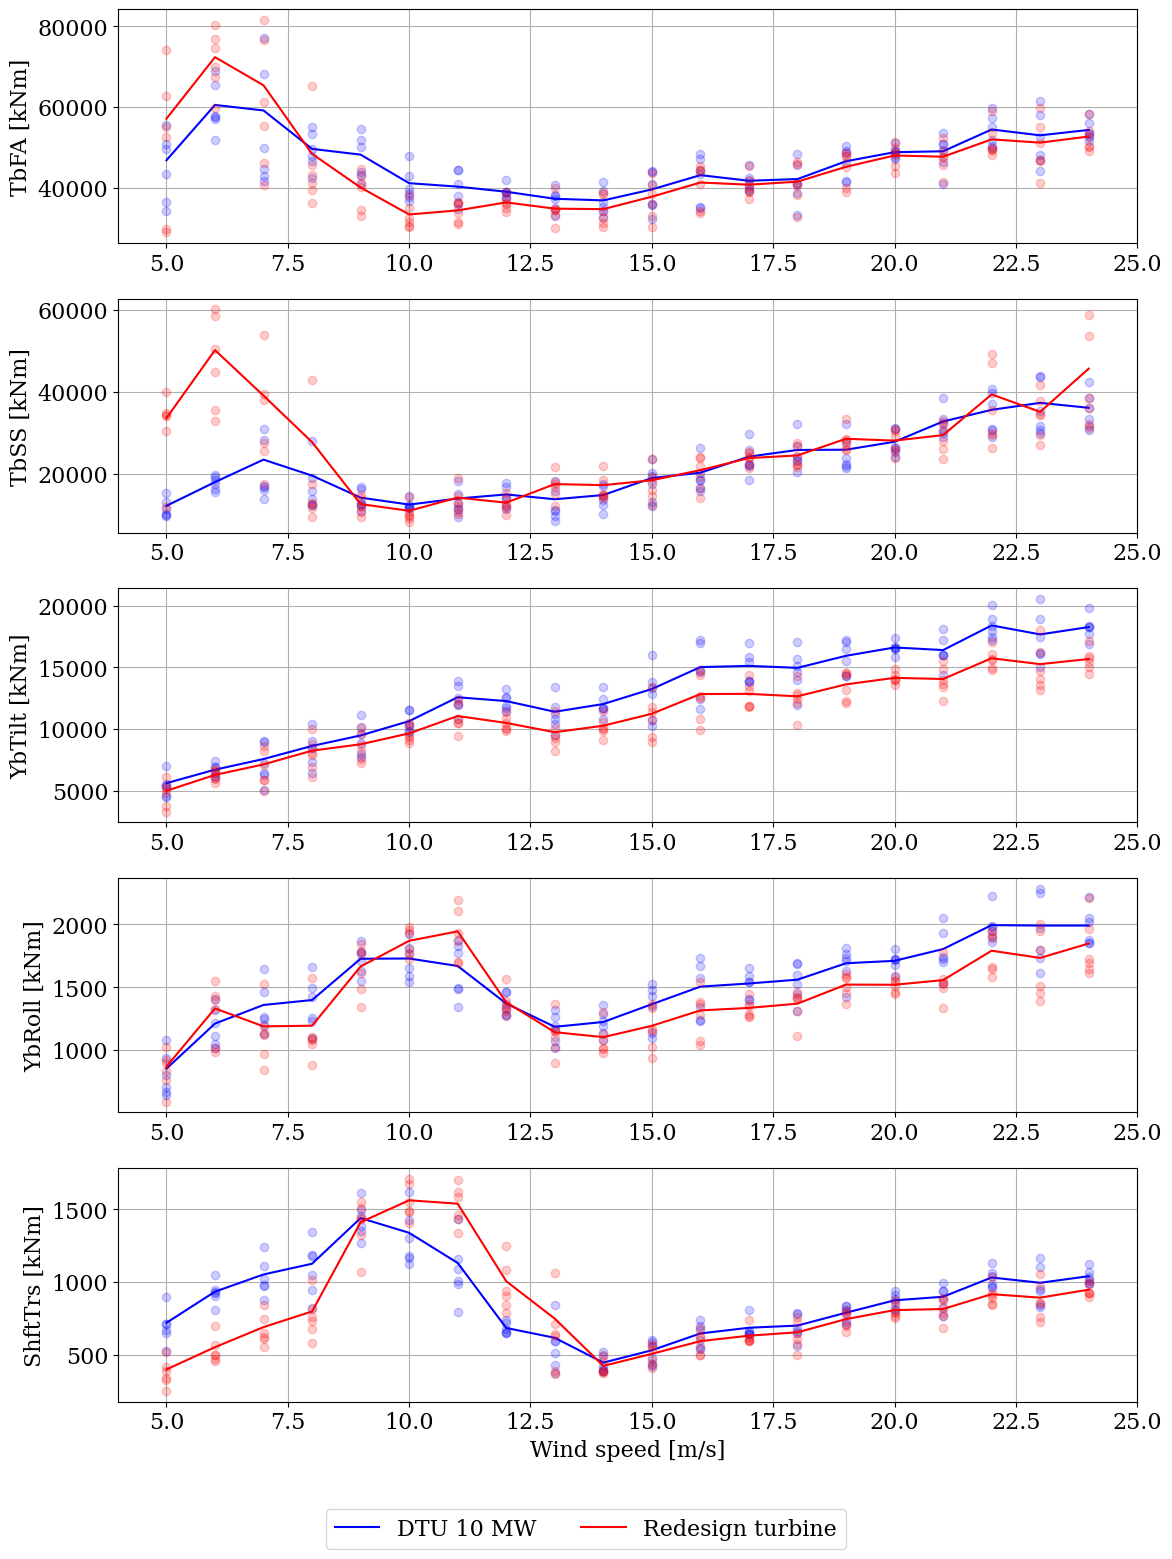

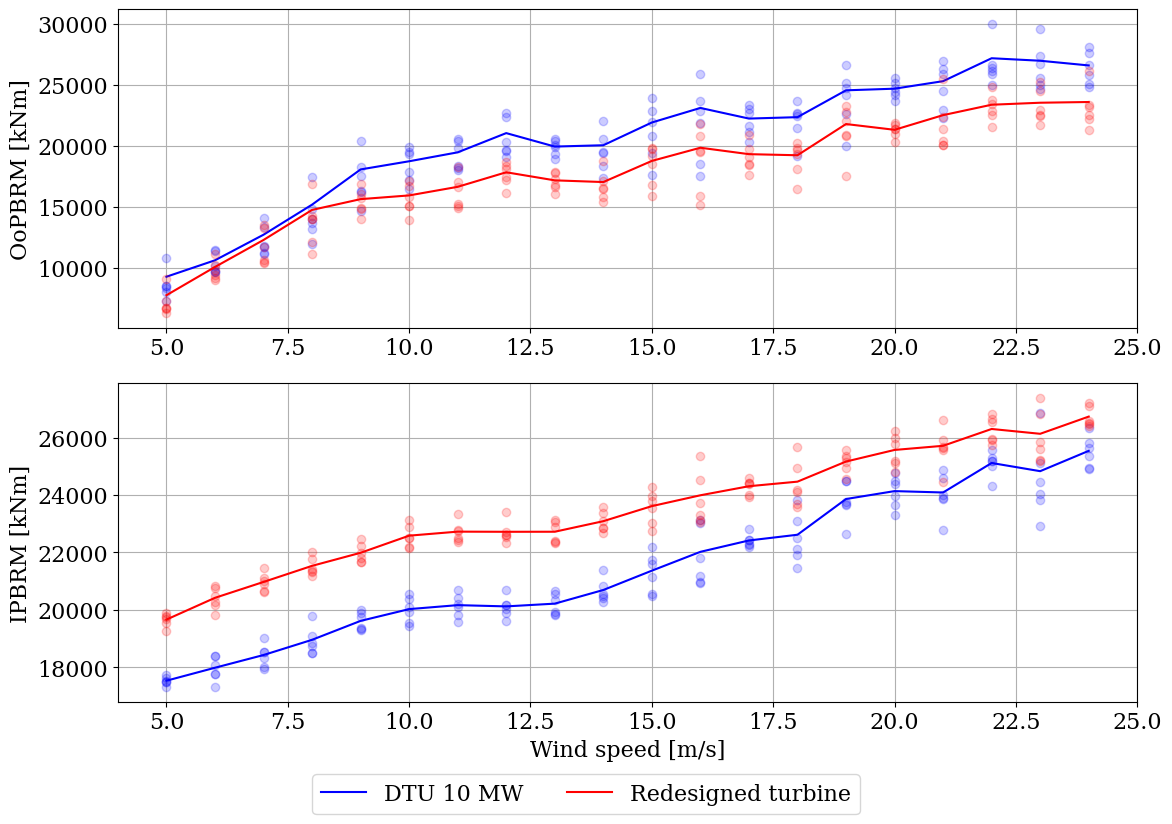

In [113]:
# DEL calculation, nice function

# still missing: correct R_eql calculation, compute bin probabilities, Distribution of lifetime cycles in each bin


# wohler exponent 4 (del4)   :  TbFA, TbSS, YbTilt, YbRoll, ShftTrs, 
# wohler exponent 10 (del10) :  OoPBRM, IPBRM, 
# Lifetime equivalent cycles : 10000000
# 10-min DELs


#STATS_PATH = 'dtu_10mw_turb_stats.hdf5'  
STATS_PATH = 'Group1_turb.csv'

SUBFOLDER = 'tcb'  

CHAN_DESCS = {'BldPit': 'pitch1 angle',  # dictionary used to identify which descriptions
              'RotSpd': 'rotor speed',  # in the HAWC2 statistics file correspond to which
              'Thrust': 'aero rotor thrust',  # channels we want
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

value_list = ['min', 'mean', 'max']
color_list = ['b', 'r', 'g']

# list of considered elements
wohler_4 = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs']
wohler_10 =  ['OoPBRM', 'IPBRM']


# wohler parameters
n_life = 1e7                # standard lifetime
n_seed = 6                  # number of used seed/ number of realizations
n_eq = 10*60                # equivalent number of cycles for 10 minutes 
n_t = 20*365*24*60*60       # equivalent number of cycles for 20 years

# compute ourselves
ws_bin = [4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 
          14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5]
ws_prob = [0.06442809, 0.0709227, 0.07472189, 0.07591763, 0.0747455, 0.07155162,
           0.06675382, 0.06080169, 0.05413969, 0.04717648, 0.04026251, 0.03367663,
           0.02762128, 0.02222493, 0.01755019, 0.01360521, 0.01035688, 0.00774379,
           0.00568809, 0.0041053]
R_eql_solution = [129826.22850291798, 55207.14541461715, 32488.017318558606, 4039.5407105388217, 
                       2839.4652325826987, 31335.803816820186,31017.45970934247]


data_DTU = DEL_calculation('dtu_10mw_turb_stats.hdf5', 'tca', chan_ids, CHAN_DESCS, wohler_4, wohler_10, ws_prob)
data_redesign = DEL_calculation('Group1_turb.csv', 'tcb', chan_ids, CHAN_DESCS, wohler_4, wohler_10, ws_prob)


# table of used wohler exponents
print(f'   element     |   meterial  |    wohler exp    ')
for iplot, chan_id in enumerate(wohler_4):
    print(f"   {chan_id:10}  |    metal    | {data_redesign[chan_id]['wohler_exp']:10.1f} ")
for iplot, chan_id in enumerate(wohler_10):
    print(f"   {chan_id:10}  |  composite  | {data_redesign[chan_id]['wohler_exp']:10.1f} ")
print('')

# table of mismatch for DTU
print(f'element     |  DTU computed  |   DTU given   |    difference    ')
for iplot, chan_id in enumerate(wohler_4 + wohler_10):
    print(f"{chan_id:10}  |{data_DTU[chan_id]['R_eql']:14.2f}  | {R_eql_solution[iplot]:12.2f}  | {(data_DTU[chan_id]['R_eql'] - R_eql_solution[iplot]) / R_eql_solution[iplot] * 100:10.2f} %")


fig, axs = plt.subplots(5, 1, figsize=(12, 15), clear=True)

for iplot, chan_id in enumerate(wohler_4):

    ax = axs.flatten()[iplot]
    ax.plot(data_DTU[chan_id]['scatter_wind'], data_DTU[chan_id]['scatter_load'], 'o', alpha = 0.2, color=color_list[0])
    ax.plot(data_DTU[chan_id]['ws'], data_DTU[chan_id]['R_eq'], color=color_list[0], label='DTU 10 MW'if iplot == 0 else "")

    ax.plot(data_redesign[chan_id]['scatter_wind'], data_redesign[chan_id]['scatter_load'], 'o', alpha = 0.2, color=color_list[1])
    ax.plot(data_redesign[chan_id]['ws'], data_redesign[chan_id]['R_eq'], color=color_list[1], label='Redesign turbine'if iplot == 0 else "")

    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot >  3 else None,
           ylabel=f'{chan_id} [kNm]', xlim=[4, 25])


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)
#axs[0,0].legend()
fig.tight_layout()
fig.savefig(f'plots/DLS_DTU_tca_Redesigned_tcb_steel.pdf', format='pdf',bbox_inches='tight')
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(12, 8), clear=True)

for iplot, chan_id in enumerate(wohler_10):

    ax = axs.flatten()[iplot]
    ax.plot(data_DTU[chan_id]['scatter_wind'], data_DTU[chan_id]['scatter_load'], 'o', alpha = 0.2, color=color_list[0])
    ax.plot(data_DTU[chan_id]['ws'], data_DTU[chan_id]['R_eq'], color=color_list[0], label='DTU 10 MW'if iplot == 0 else "")

    ax.plot(data_redesign[chan_id]['scatter_wind'], data_redesign[chan_id]['scatter_load'], 'o', alpha = 0.2, color=color_list[1])
    ax.plot(data_redesign[chan_id]['ws'], data_redesign[chan_id]['R_eq'], color=color_list[1], label='Redesigned turbine'if iplot == 0 else "")

    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot >=  1 else None,
           ylabel=f'{chan_id} [kNm]', xlim=[4, 25])


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)
fig.tight_layout()
fig.savefig(f'plots/DLS_DTU_tca_Redesigned_tcb_composites.pdf', format='pdf',bbox_inches='tight')
plt.show()
